## MMD ResNet for RNA data - Quantile Normalized

Use GTEX as source and TCGA as target since there are 2445 GTEX samples and only 683 TCGA samples

### Imports

In [1]:
import os.path
import keras.optimizers
from Calibration_Util import DataHandler as dh 
from Calibration_Util import FileIO as io
from keras.layers import Input, Dense, merge, Activation, add
from keras.models import Model
from keras import callbacks as cb
import numpy as np
import matplotlib
from keras.layers.normalization import BatchNormalization
#detect display
import os
havedisplay = "DISPLAY" in os.environ
#if we have a display use a plotting backend
if havedisplay:
    matplotlib.use('TkAgg')
else:
    matplotlib.use('Agg')

import CostFunctions as cf
import Monitoring as mn
from keras.regularizers import l2
from sklearn import decomposition
from keras.callbacks import LearningRateScheduler
import math
import ScatterHist as sh
from keras import initializers
from numpy import genfromtxt
import sklearn.preprocessing as prep
import tensorflow as tf
import keras.backend as K

import pandas as pd

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Configure hyperparameters

In [2]:
mmdNetLayerSizes = [20, 20]
l2_penalty = 1e-2

### Load Data

In [3]:
# sourcePath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch1-gtex-20PCs.csv')
# targetPath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch2-tcga-20PCs.csv')

sourceFileName = 'unnorm-qn-20PC-GTEX-breast-prostate-thyroid.csv'
targetFileName = 'unnorm-qn-20PC-TCGA-breast-prostate-thyroid.csv'

sourcePath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + sourceFileName)
targetPath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + targetFileName)

In [4]:
# source = genfromtxt(sourcePath, delimiter=',', skip_header=1)
# target = genfromtxt(targetPath, delimiter=',', skip_header=1)

source = pd.read_csv(sourcePath, sep=',', header=0, index_col=0)
target = pd.read_csv(targetPath, sep=',', header=0, index_col=0)



In [5]:
source[["PC1", "PC2"]][0:4]

,PC1,PC2
GTEX.breast,-1045.388174,-69.278998
GTEX.breast.1,-1039.645947,-47.799101
GTEX.breast.2,-1045.533655,-78.585359
GTEX.breast.3,-1043.787094,-70.776803


In [6]:
target[["PC1", "PC2"]][0:4]

,PC1,PC2
TCGA.breast,-1040.720188,-94.332494
TCGA.breast.1,-1037.086656,-73.924512
TCGA.breast.2,-1042.328732,-86.102301
TCGA.breast.3,-1040.036569,-89.419399


In [7]:
source = source.values
target = target.values

In [8]:
print(source[0:4, 0:2])
print(target[0:4, 0:2])

inputDim = target.shape[1]
print("inputDim = " + str(inputDim))

[[-1045.38817359   -69.27899809]
 [-1039.64594732   -47.79910136]
 [-1045.5336552    -78.58535871]
 [-1043.78709351   -70.77680287]]
[[-1040.7201884    -94.33249386]
 [-1037.08665589   -73.92451195]
 [-1042.32873248   -86.10230122]
 [-1040.03656876   -89.4193985 ]]
inputDim = 20


In [9]:
print("gtex = source shape = " + str(source.shape))
print("tcga = target shape = " + str(target.shape))

gtex = source shape = (636, 20)
tcga = target shape = (211, 20)


### Build MMD Net

In [10]:
# input
calibInput = Input(shape=(inputDim, ))

# block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)
block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2)
block1_output = add([block1_w2, calibInput])

# block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1)
block2_bn2 = BatchNormalization()(block1_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2)
block2_output = add([block2_w2, calibInput])

# block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2)
block3_output = add([block3_w2, calibInput])

calibMMDNet = Model(inputs=calibInput, outputs=block3_output)

### Prepare for Training

In [11]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

# optimizer = keras.optimizers.rmsprop(lr=0.0)
optimizer = keras.optimizers.Adam()

calibMMDNet.compile(optimizer=optimizer, 
                    loss=lambda y_true,y_pred: 
                       cf.MMD(block3_output, target, MMDTargetValidation_split=0.1,
                             MMDTargetSampleSize=100, n_neighbors=10).KerasCost(y_true,y_pred)
                   )

K.get_session().run(tf.global_variables_initializer())

sourceLabels = np.zeros(source.shape)
sourceLabels.shape

setting scales using KNN
[22.682515077192555, 45.36503015438511, 90.73006030877022]
setting all scale weights to 1


(636, 20)

### Train

In [12]:
#calibMMDNet.fit(source, sourceLabels, epochs=500 ,batch_size=10, validation_split=0.1, verbose=1,
#               callbacks=[lrate, mn.monitorMMD(source, target, calibMMDNet.predict),
#                          cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')]
#               )

calibMMDNet.fit(source, sourceLabels, epochs=5000, batch_size=20, validation_split=0.1, verbose=1)

Train on 572 samples, validate on 64 samples
Epoch 1/5000
572/572 [==============================] - 1s 1ms/step - loss: 1.2896 - val_loss: 1.8627
Epoch 2/5000
572/572 [==============================] - 0s 483us/step - loss: 1.2927 - val_loss: 1.8631
Epoch 3/5000
572/572 [==============================] - 0s 489us/step - loss: 1.2958 - val_loss: 1.8633
Epoch 4/5000
572/572 [==============================] - 0s 490us/step - loss: 1.2879 - val_loss: 1.8632
Epoch 5/5000
572/572 [==============================] - 0s 492us/step - loss: 1.2947 - val_loss: 1.8632
Epoch 6/5000
572/572 [==============================] - 0s 479us/step - loss: 1.2920 - val_loss: 1.8629
Epoch 7/5000
572/572 [==============================] - 0s 482us/step - loss: 1.2855 - val_loss: 1.8628
Epoch 8/5000
572/572 [==============================] - 0s 487us/step - loss: 1.2922 - val_loss: 1.8621
Epoch 9/5000
572/572 [==============================] - 0s 483us/step - loss: 1.2910 - val_loss: 1.8616
Epoch 10/5000
572/572

572/572 [==============================] - 0s 671us/step - loss: 1.1746 - val_loss: 1.7397
Epoch 79/5000
572/572 [==============================] - 0s 675us/step - loss: 1.1701 - val_loss: 1.7348
Epoch 80/5000
572/572 [==============================] - 0s 668us/step - loss: 1.1768 - val_loss: 1.7667
Epoch 81/5000
572/572 [==============================] - 0s 652us/step - loss: 1.1795 - val_loss: 1.7408
Epoch 82/5000
572/572 [==============================] - 0s 647us/step - loss: 1.1679 - val_loss: 1.7456
Epoch 83/5000
572/572 [==============================] - 0s 679us/step - loss: 1.1728 - val_loss: 1.7510
Epoch 84/5000
572/572 [==============================] - 0s 666us/step - loss: 1.1746 - val_loss: 1.7458
Epoch 85/5000
572/572 [==============================] - 0s 680us/step - loss: 1.1711 - val_loss: 1.7465
Epoch 86/5000
572/572 [==============================] - 0s 651us/step - loss: 1.1682 - val_loss: 1.7478
Epoch 87/5000
572/572 [==============================] - 0s 670us/ste

572/572 [==============================] - 0s 661us/step - loss: 1.1142 - val_loss: 1.6697
Epoch 156/5000
572/572 [==============================] - 0s 666us/step - loss: 1.1128 - val_loss: 1.6627
Epoch 157/5000
572/572 [==============================] - 0s 686us/step - loss: 1.1031 - val_loss: 1.6596
Epoch 158/5000
572/572 [==============================] - 0s 676us/step - loss: 1.1101 - val_loss: 1.6698
Epoch 159/5000
572/572 [==============================] - 0s 675us/step - loss: 1.1145 - val_loss: 1.6690
Epoch 160/5000
572/572 [==============================] - 0s 676us/step - loss: 1.1174 - val_loss: 1.6775
Epoch 161/5000
572/572 [==============================] - 0s 646us/step - loss: 1.1134 - val_loss: 1.6789
Epoch 162/5000
572/572 [==============================] - 0s 671us/step - loss: 1.1124 - val_loss: 1.6531
Epoch 163/5000
572/572 [==============================] - 0s 655us/step - loss: 1.1038 - val_loss: 1.6535
Epoch 164/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 648us/step - loss: 1.0488 - val_loss: 1.5082
Epoch 233/5000
572/572 [==============================] - 0s 669us/step - loss: 1.0436 - val_loss: 1.5075
Epoch 234/5000
572/572 [==============================] - 0s 629us/step - loss: 1.0485 - val_loss: 1.5034
Epoch 235/5000
572/572 [==============================] - 0s 667us/step - loss: 1.0480 - val_loss: 1.5094
Epoch 236/5000
572/572 [==============================] - 0s 676us/step - loss: 1.0411 - val_loss: 1.5060
Epoch 237/5000
572/572 [==============================] - 0s 645us/step - loss: 1.0452 - val_loss: 1.5109
Epoch 238/5000
572/572 [==============================] - 0s 670us/step - loss: 1.0389 - val_loss: 1.5097
Epoch 239/5000
572/572 [==============================] - 0s 671us/step - loss: 1.0401 - val_loss: 1.5071
Epoch 240/5000
572/572 [==============================] - 0s 640us/step - loss: 1.0417 - val_loss: 1.4973
Epoch 241/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 660us/step - loss: 1.0096 - val_loss: 1.5054
Epoch 310/5000
572/572 [==============================] - 0s 690us/step - loss: 0.9953 - val_loss: 1.4995
Epoch 311/5000
572/572 [==============================] - 0s 629us/step - loss: 1.0026 - val_loss: 1.5021
Epoch 312/5000
572/572 [==============================] - 0s 668us/step - loss: 0.9941 - val_loss: 1.5140
Epoch 313/5000
572/572 [==============================] - 0s 679us/step - loss: 0.9940 - val_loss: 1.5007
Epoch 314/5000
572/572 [==============================] - 0s 662us/step - loss: 0.9889 - val_loss: 1.5063
Epoch 315/5000
572/572 [==============================] - 0s 707us/step - loss: 0.9829 - val_loss: 1.5024
Epoch 316/5000
572/572 [==============================] - 0s 668us/step - loss: 0.9858 - val_loss: 1.5035
Epoch 317/5000
572/572 [==============================] - 0s 666us/step - loss: 0.9919 - val_loss: 1.5081
Epoch 318/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 669us/step - loss: 0.9768 - val_loss: 1.4942
Epoch 387/5000
572/572 [==============================] - 0s 647us/step - loss: 0.9671 - val_loss: 1.4925
Epoch 388/5000
572/572 [==============================] - 0s 662us/step - loss: 0.9602 - val_loss: 1.4981
Epoch 389/5000
572/572 [==============================] - 0s 646us/step - loss: 0.9688 - val_loss: 1.5014
Epoch 390/5000
572/572 [==============================] - 0s 668us/step - loss: 0.9543 - val_loss: 1.4917
Epoch 391/5000
572/572 [==============================] - 0s 670us/step - loss: 0.9525 - val_loss: 1.4899
Epoch 392/5000
572/572 [==============================] - 0s 720us/step - loss: 0.9604 - val_loss: 1.4979
Epoch 393/5000
572/572 [==============================] - 0s 662us/step - loss: 0.9614 - val_loss: 1.4924
Epoch 394/5000
572/572 [==============================] - 0s 666us/step - loss: 0.9554 - val_loss: 1.5002
Epoch 395/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 647us/step - loss: 0.9559 - val_loss: 1.5024
Epoch 464/5000
572/572 [==============================] - 0s 710us/step - loss: 0.9475 - val_loss: 1.4868
Epoch 465/5000
572/572 [==============================] - 0s 674us/step - loss: 0.9471 - val_loss: 1.4908
Epoch 466/5000
572/572 [==============================] - 0s 671us/step - loss: 0.9363 - val_loss: 1.4858
Epoch 467/5000
572/572 [==============================] - 0s 669us/step - loss: 0.9362 - val_loss: 1.4870
Epoch 468/5000
572/572 [==============================] - 0s 643us/step - loss: 0.9397 - val_loss: 1.4950
Epoch 469/5000
572/572 [==============================] - 0s 674us/step - loss: 0.9316 - val_loss: 1.4853
Epoch 470/5000
572/572 [==============================] - 0s 655us/step - loss: 0.9351 - val_loss: 1.5025
Epoch 471/5000
572/572 [==============================] - 0s 687us/step - loss: 0.9406 - val_loss: 1.5068
Epoch 472/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 640us/step - loss: 0.9221 - val_loss: 1.4961
Epoch 541/5000
572/572 [==============================] - 0s 638us/step - loss: 0.9270 - val_loss: 1.4818
Epoch 542/5000
572/572 [==============================] - 0s 660us/step - loss: 0.9183 - val_loss: 1.4896
Epoch 543/5000
572/572 [==============================] - 0s 692us/step - loss: 0.9152 - val_loss: 1.4890
Epoch 544/5000
572/572 [==============================] - 0s 678us/step - loss: 0.9213 - val_loss: 1.4972
Epoch 545/5000
572/572 [==============================] - 0s 665us/step - loss: 0.9297 - val_loss: 1.4919
Epoch 546/5000
572/572 [==============================] - 0s 680us/step - loss: 0.9310 - val_loss: 1.4907
Epoch 547/5000
572/572 [==============================] - 0s 677us/step - loss: 0.9335 - val_loss: 1.4942
Epoch 548/5000
572/572 [==============================] - 0s 680us/step - loss: 0.9288 - val_loss: 1.4896
Epoch 549/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 631us/step - loss: 0.9114 - val_loss: 1.4922
Epoch 618/5000
572/572 [==============================] - 0s 679us/step - loss: 0.9200 - val_loss: 1.4822
Epoch 619/5000
572/572 [==============================] - 0s 671us/step - loss: 0.9136 - val_loss: 1.4825
Epoch 620/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8998 - val_loss: 1.4917
Epoch 621/5000
572/572 [==============================] - 0s 662us/step - loss: 0.9078 - val_loss: 1.4855
Epoch 622/5000
572/572 [==============================] - 0s 619us/step - loss: 0.9134 - val_loss: 1.4818
Epoch 623/5000
572/572 [==============================] - 0s 653us/step - loss: 0.9150 - val_loss: 1.4892
Epoch 624/5000
572/572 [==============================] - 0s 635us/step - loss: 0.9033 - val_loss: 1.4822
Epoch 625/5000
572/572 [==============================] - 0s 685us/step - loss: 0.9105 - val_loss: 1.4829
Epoch 626/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 646us/step - loss: 0.8986 - val_loss: 1.4649
Epoch 695/5000
572/572 [==============================] - 0s 646us/step - loss: 0.9035 - val_loss: 1.4701
Epoch 696/5000
572/572 [==============================] - 0s 669us/step - loss: 0.9122 - val_loss: 1.4614
Epoch 697/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8996 - val_loss: 1.4698
Epoch 698/5000
572/572 [==============================] - 0s 666us/step - loss: 0.8974 - val_loss: 1.4762
Epoch 699/5000
572/572 [==============================] - 0s 674us/step - loss: 0.8981 - val_loss: 1.4688
Epoch 700/5000
572/572 [==============================] - 0s 640us/step - loss: 0.9032 - val_loss: 1.4831
Epoch 701/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8916 - val_loss: 1.4688
Epoch 702/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8841 - val_loss: 1.4664
Epoch 703/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 649us/step - loss: 0.8933 - val_loss: 1.4714
Epoch 772/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8897 - val_loss: 1.4626
Epoch 773/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8956 - val_loss: 1.4663
Epoch 774/5000
572/572 [==============================] - 0s 683us/step - loss: 0.8992 - val_loss: 1.4630
Epoch 775/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8934 - val_loss: 1.4928
Epoch 776/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8947 - val_loss: 1.4817
Epoch 777/5000
572/572 [==============================] - 0s 664us/step - loss: 0.8863 - val_loss: 1.4657
Epoch 778/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8929 - val_loss: 1.4563
Epoch 779/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8945 - val_loss: 1.4527
Epoch 780/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 640us/step - loss: 0.8747 - val_loss: 1.4679
Epoch 849/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8802 - val_loss: 1.4520
Epoch 850/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8968 - val_loss: 1.4838
Epoch 851/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8710 - val_loss: 1.4516
Epoch 852/5000
572/572 [==============================] - 0s 666us/step - loss: 0.8787 - val_loss: 1.4506
Epoch 853/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8865 - val_loss: 1.4436
Epoch 854/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8871 - val_loss: 1.4626
Epoch 855/5000
572/572 [==============================] - 0s 632us/step - loss: 0.8883 - val_loss: 1.4582
Epoch 856/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8854 - val_loss: 1.4538
Epoch 857/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 624us/step - loss: 0.8722 - val_loss: 1.4452
Epoch 926/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8854 - val_loss: 1.4583
Epoch 927/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8803 - val_loss: 1.4397
Epoch 928/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8712 - val_loss: 1.4351
Epoch 929/5000
572/572 [==============================] - 0s 679us/step - loss: 0.8693 - val_loss: 1.4433
Epoch 930/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8816 - val_loss: 1.4315
Epoch 931/5000
572/572 [==============================] - 0s 682us/step - loss: 0.8694 - val_loss: 1.4297
Epoch 932/5000
572/572 [==============================] - 0s 620us/step - loss: 0.8693 - val_loss: 1.4385
Epoch 933/5000
572/572 [==============================] - 0s 674us/step - loss: 0.8845 - val_loss: 1.4444
Epoch 934/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 644us/step - loss: 0.8868 - val_loss: 1.4537
Epoch 1003/5000
572/572 [==============================] - 0s 673us/step - loss: 0.8653 - val_loss: 1.4607
Epoch 1004/5000
572/572 [==============================] - 0s 664us/step - loss: 0.8959 - val_loss: 1.4526
Epoch 1005/5000
572/572 [==============================] - 0s 655us/step - loss: 0.8597 - val_loss: 1.4459
Epoch 1006/5000
572/572 [==============================] - 0s 655us/step - loss: 0.8775 - val_loss: 1.4476
Epoch 1007/5000
572/572 [==============================] - 0s 708us/step - loss: 0.8715 - val_loss: 1.4432
Epoch 1008/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8645 - val_loss: 1.4469
Epoch 1009/5000
572/572 [==============================] - 0s 668us/step - loss: 0.8611 - val_loss: 1.4468
Epoch 1010/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8608 - val_loss: 1.4327
Epoch 1011/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.8570 - val_loss: 1.4371
Epoch 1079/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8685 - val_loss: 1.4277
Epoch 1080/5000
572/572 [==============================] - 0s 767us/step - loss: 0.8597 - val_loss: 1.4381
Epoch 1081/5000
572/572 [==============================] - 0s 854us/step - loss: 0.8643 - val_loss: 1.4381
Epoch 1082/5000
572/572 [==============================] - 0s 842us/step - loss: 0.8684 - val_loss: 1.4444
Epoch 1083/5000
572/572 [==============================] - 0s 817us/step - loss: 0.8658 - val_loss: 1.4360
Epoch 1084/5000
572/572 [==============================] - 0s 798us/step - loss: 0.8632 - val_loss: 1.4440
Epoch 1085/5000
572/572 [==============================] - 0s 812us/step - loss: 0.8629 - val_loss: 1.4136
Epoch 1086/5000
572/572 [==============================] - 0s 847us/step - loss: 0.8618 - val_loss: 1.4160
Epoch 1087/5000
572/572 [============================

572/572 [==============================] - 0s 652us/step - loss: 0.8550 - val_loss: 1.4333
Epoch 1155/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8533 - val_loss: 1.4216
Epoch 1156/5000
572/572 [==============================] - 0s 632us/step - loss: 0.8579 - val_loss: 1.4154
Epoch 1157/5000
572/572 [==============================] - 0s 679us/step - loss: 0.8598 - val_loss: 1.4467
Epoch 1158/5000
572/572 [==============================] - 0s 629us/step - loss: 0.8719 - val_loss: 1.4220
Epoch 1159/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8527 - val_loss: 1.4192
Epoch 1160/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8558 - val_loss: 1.4249
Epoch 1161/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8628 - val_loss: 1.4413
Epoch 1162/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8533 - val_loss: 1.4313
Epoch 1163/5000
572/572 [============================

572/572 [==============================] - 0s 654us/step - loss: 0.8531 - val_loss: 1.4368
Epoch 1231/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8653 - val_loss: 1.5066
Epoch 1232/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8632 - val_loss: 1.4529
Epoch 1233/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8602 - val_loss: 1.4348
Epoch 1234/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8575 - val_loss: 1.4173
Epoch 1235/5000
572/572 [==============================] - 0s 668us/step - loss: 0.8518 - val_loss: 1.4112
Epoch 1236/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8566 - val_loss: 1.4257
Epoch 1237/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8465 - val_loss: 1.4443
Epoch 1238/5000
572/572 [==============================] - 0s 655us/step - loss: 0.8672 - val_loss: 1.4267
Epoch 1239/5000
572/572 [============================

572/572 [==============================] - 0s 640us/step - loss: 0.8747 - val_loss: 1.4555
Epoch 1307/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8351 - val_loss: 1.4336
Epoch 1308/5000
572/572 [==============================] - 0s 633us/step - loss: 0.8564 - val_loss: 1.4503
Epoch 1309/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8698 - val_loss: 1.4471
Epoch 1310/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8699 - val_loss: 1.4125
Epoch 1311/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8573 - val_loss: 1.4265
Epoch 1312/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8519 - val_loss: 1.4296
Epoch 1313/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8524 - val_loss: 1.4356
Epoch 1314/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8478 - val_loss: 1.4627
Epoch 1315/5000
572/572 [============================

572/572 [==============================] - 0s 650us/step - loss: 0.8464 - val_loss: 1.4115
Epoch 1383/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8410 - val_loss: 1.4790
Epoch 1384/5000
572/572 [==============================] - 0s 681us/step - loss: 0.8561 - val_loss: 1.4877
Epoch 1385/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8491 - val_loss: 1.4713
Epoch 1386/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8452 - val_loss: 1.4204
Epoch 1387/5000
572/572 [==============================] - 0s 630us/step - loss: 0.8509 - val_loss: 1.4149
Epoch 1388/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8578 - val_loss: 1.4284
Epoch 1389/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8436 - val_loss: 1.4162
Epoch 1390/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8445 - val_loss: 1.4378
Epoch 1391/5000
572/572 [============================

572/572 [==============================] - 0s 670us/step - loss: 0.8493 - val_loss: 1.4304
Epoch 1459/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8437 - val_loss: 1.4531
Epoch 1460/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8479 - val_loss: 1.4461
Epoch 1461/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8434 - val_loss: 1.4453
Epoch 1462/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8366 - val_loss: 1.4384
Epoch 1463/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8571 - val_loss: 1.4349
Epoch 1464/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8406 - val_loss: 1.4584
Epoch 1465/5000
572/572 [==============================] - 0s 691us/step - loss: 0.8602 - val_loss: 1.4754
Epoch 1466/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8469 - val_loss: 1.4118
Epoch 1467/5000
572/572 [============================

572/572 [==============================] - 0s 651us/step - loss: 0.8431 - val_loss: 1.4485
Epoch 1535/5000
572/572 [==============================] - 0s 633us/step - loss: 0.8495 - val_loss: 1.4215
Epoch 1536/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8394 - val_loss: 1.4280
Epoch 1537/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8351 - val_loss: 1.4100
Epoch 1538/5000
572/572 [==============================] - 0s 627us/step - loss: 0.8465 - val_loss: 1.4453
Epoch 1539/5000
572/572 [==============================] - 0s 626us/step - loss: 0.8296 - val_loss: 1.4005
Epoch 1540/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8521 - val_loss: 1.4016
Epoch 1541/5000
572/572 [==============================] - 0s 619us/step - loss: 0.8377 - val_loss: 1.3891
Epoch 1542/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8348 - val_loss: 1.4097
Epoch 1543/5000
572/572 [============================

572/572 [==============================] - 0s 691us/step - loss: 0.8442 - val_loss: 1.4353
Epoch 1611/5000
572/572 [==============================] - 0s 719us/step - loss: 0.8393 - val_loss: 1.4135
Epoch 1612/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8317 - val_loss: 1.4076
Epoch 1613/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8435 - val_loss: 1.4208
Epoch 1614/5000
572/572 [==============================] - 0s 629us/step - loss: 0.8445 - val_loss: 1.4483
Epoch 1615/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8488 - val_loss: 1.4100
Epoch 1616/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8332 - val_loss: 1.4267
Epoch 1617/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8421 - val_loss: 1.4279
Epoch 1618/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8361 - val_loss: 1.4446
Epoch 1619/5000
572/572 [============================

572/572 [==============================] - 0s 626us/step - loss: 0.8309 - val_loss: 1.4514
Epoch 1687/5000
572/572 [==============================] - 0s 637us/step - loss: 0.8419 - val_loss: 1.4390
Epoch 1688/5000
572/572 [==============================] - 0s 668us/step - loss: 0.8580 - val_loss: 1.4328
Epoch 1689/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8427 - val_loss: 1.4570
Epoch 1690/5000
572/572 [==============================] - 0s 638us/step - loss: 0.8382 - val_loss: 1.4251
Epoch 1691/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8307 - val_loss: 1.4445
Epoch 1692/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8411 - val_loss: 1.4752
Epoch 1693/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8185 - val_loss: 1.4276
Epoch 1694/5000
572/572 [==============================] - 0s 611us/step - loss: 0.8368 - val_loss: 1.4281
Epoch 1695/5000
572/572 [============================

572/572 [==============================] - 0s 668us/step - loss: 0.8371 - val_loss: 1.4405
Epoch 1763/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8348 - val_loss: 1.4235
Epoch 1764/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8384 - val_loss: 1.4445
Epoch 1765/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8289 - val_loss: 1.3907
Epoch 1766/5000
572/572 [==============================] - 0s 684us/step - loss: 0.8331 - val_loss: 1.4362
Epoch 1767/5000
572/572 [==============================] - 0s 626us/step - loss: 0.8425 - val_loss: 1.4517
Epoch 1768/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8500 - val_loss: 1.4888
Epoch 1769/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8238 - val_loss: 1.4280
Epoch 1770/5000
572/572 [==============================] - 0s 632us/step - loss: 0.8395 - val_loss: 1.4141
Epoch 1771/5000
572/572 [============================

572/572 [==============================] - 0s 675us/step - loss: 0.8404 - val_loss: 1.3960
Epoch 1839/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8376 - val_loss: 1.4565
Epoch 1840/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8293 - val_loss: 1.4555
Epoch 1841/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8299 - val_loss: 1.4175
Epoch 1842/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8290 - val_loss: 1.3902
Epoch 1843/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8426 - val_loss: 1.4464
Epoch 1844/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8338 - val_loss: 1.4526
Epoch 1845/5000
572/572 [==============================] - 0s 655us/step - loss: 0.8449 - val_loss: 1.4507
Epoch 1846/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8508 - val_loss: 1.4076
Epoch 1847/5000
572/572 [============================

572/572 [==============================] - 0s 611us/step - loss: 0.8406 - val_loss: 1.3976
Epoch 1915/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8248 - val_loss: 1.4123
Epoch 1916/5000
572/572 [==============================] - 0s 686us/step - loss: 0.8417 - val_loss: 1.4413
Epoch 1917/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8347 - val_loss: 1.4395
Epoch 1918/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8320 - val_loss: 1.4230
Epoch 1919/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8484 - val_loss: 1.4269
Epoch 1920/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8470 - val_loss: 1.4146
Epoch 1921/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8413 - val_loss: 1.4002
Epoch 1922/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8268 - val_loss: 1.4228
Epoch 1923/5000
572/572 [============================

572/572 [==============================] - 0s 670us/step - loss: 0.8206 - val_loss: 1.3907
Epoch 1991/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8328 - val_loss: 1.3938
Epoch 1992/5000
572/572 [==============================] - 0s 672us/step - loss: 0.8402 - val_loss: 1.4139
Epoch 1993/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8287 - val_loss: 1.4353
Epoch 1994/5000
572/572 [==============================] - 0s 664us/step - loss: 0.8395 - val_loss: 1.4275
Epoch 1995/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8247 - val_loss: 1.4222
Epoch 1996/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8286 - val_loss: 1.4258
Epoch 1997/5000
572/572 [==============================] - 0s 634us/step - loss: 0.8456 - val_loss: 1.4483
Epoch 1998/5000
572/572 [==============================] - 0s 679us/step - loss: 0.8200 - val_loss: 1.4185
Epoch 1999/5000
572/572 [============================

572/572 [==============================] - 0s 650us/step - loss: 0.8327 - val_loss: 1.3712
Epoch 2067/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8476 - val_loss: 1.3810
Epoch 2068/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8333 - val_loss: 1.3826
Epoch 2069/5000
572/572 [==============================] - 0s 638us/step - loss: 0.8481 - val_loss: 1.3931
Epoch 2070/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8047 - val_loss: 1.4067
Epoch 2071/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8380 - val_loss: 1.3842
Epoch 2072/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8517 - val_loss: 1.3976
Epoch 2073/5000
572/572 [==============================] - 0s 669us/step - loss: 0.8199 - val_loss: 1.3866
Epoch 2074/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8194 - val_loss: 1.4092
Epoch 2075/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.8312 - val_loss: 1.3802
Epoch 2143/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8320 - val_loss: 1.4233
Epoch 2144/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8211 - val_loss: 1.4186
Epoch 2145/5000
572/572 [==============================] - 0s 678us/step - loss: 0.8503 - val_loss: 1.4223
Epoch 2146/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8371 - val_loss: 1.3975
Epoch 2147/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8357 - val_loss: 1.3771
Epoch 2148/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8413 - val_loss: 1.4187
Epoch 2149/5000
572/572 [==============================] - 0s 616us/step - loss: 0.8163 - val_loss: 1.4048
Epoch 2150/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8190 - val_loss: 1.4103
Epoch 2151/5000
572/572 [============================

572/572 [==============================] - 0s 643us/step - loss: 0.8285 - val_loss: 1.4096
Epoch 2219/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8288 - val_loss: 1.3777
Epoch 2220/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8188 - val_loss: 1.4197
Epoch 2221/5000
572/572 [==============================] - 0s 681us/step - loss: 0.8173 - val_loss: 1.3967
Epoch 2222/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8257 - val_loss: 1.4164
Epoch 2223/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8253 - val_loss: 1.4618
Epoch 2224/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8213 - val_loss: 1.5024
Epoch 2225/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8371 - val_loss: 1.4357
Epoch 2226/5000
572/572 [==============================] - 0s 691us/step - loss: 0.8346 - val_loss: 1.4398
Epoch 2227/5000
572/572 [============================

572/572 [==============================] - 0s 669us/step - loss: 0.8254 - val_loss: 1.4241
Epoch 2295/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8404 - val_loss: 1.4157
Epoch 2296/5000
572/572 [==============================] - 0s 672us/step - loss: 0.8121 - val_loss: 1.3911
Epoch 2297/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8245 - val_loss: 1.3956
Epoch 2298/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8332 - val_loss: 1.3710
Epoch 2299/5000
572/572 [==============================] - 0s 674us/step - loss: 0.8447 - val_loss: 1.4096
Epoch 2300/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8261 - val_loss: 1.4048
Epoch 2301/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8255 - val_loss: 1.3746
Epoch 2302/5000
572/572 [==============================] - 0s 622us/step - loss: 0.8178 - val_loss: 1.4332
Epoch 2303/5000
572/572 [============================

572/572 [==============================] - 0s 663us/step - loss: 0.8300 - val_loss: 1.4029
Epoch 2371/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8311 - val_loss: 1.4080
Epoch 2372/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8193 - val_loss: 1.4002
Epoch 2373/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8359 - val_loss: 1.3890
Epoch 2374/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8274 - val_loss: 1.4307
Epoch 2375/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8215 - val_loss: 1.3964
Epoch 2376/5000
572/572 [==============================] - 0s 683us/step - loss: 0.8044 - val_loss: 1.4229
Epoch 2377/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8178 - val_loss: 1.4460
Epoch 2378/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8298 - val_loss: 1.3917
Epoch 2379/5000
572/572 [============================

572/572 [==============================] - 0s 640us/step - loss: 0.8258 - val_loss: 1.4119
Epoch 2447/5000
572/572 [==============================] - 0s 677us/step - loss: 0.8248 - val_loss: 1.3989
Epoch 2448/5000
572/572 [==============================] - 0s 684us/step - loss: 0.8161 - val_loss: 1.3933
Epoch 2449/5000
572/572 [==============================] - 0s 675us/step - loss: 0.8176 - val_loss: 1.3841
Epoch 2450/5000
572/572 [==============================] - 0s 677us/step - loss: 0.8207 - val_loss: 1.4074
Epoch 2451/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8185 - val_loss: 1.4457
Epoch 2452/5000
572/572 [==============================] - 0s 633us/step - loss: 0.8127 - val_loss: 1.3975
Epoch 2453/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8248 - val_loss: 1.4174
Epoch 2454/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8254 - val_loss: 1.3927
Epoch 2455/5000
572/572 [============================

572/572 [==============================] - 0s 684us/step - loss: 0.8204 - val_loss: 1.3882
Epoch 2523/5000
572/572 [==============================] - 0s 715us/step - loss: 0.8100 - val_loss: 1.3769
Epoch 2524/5000
572/572 [==============================] - 0s 800us/step - loss: 0.8228 - val_loss: 1.3696
Epoch 2525/5000
572/572 [==============================] - 0s 761us/step - loss: 0.8341 - val_loss: 1.4340
Epoch 2526/5000
572/572 [==============================] - 0s 781us/step - loss: 0.8283 - val_loss: 1.4476
Epoch 2527/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8382 - val_loss: 1.4354
Epoch 2528/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8210 - val_loss: 1.3921
Epoch 2529/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8275 - val_loss: 1.3955
Epoch 2530/5000
572/572 [==============================] - 0s 675us/step - loss: 0.8301 - val_loss: 1.3887
Epoch 2531/5000
572/572 [============================

572/572 [==============================] - 0s 655us/step - loss: 0.8137 - val_loss: 1.3961
Epoch 2599/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8188 - val_loss: 1.3933
Epoch 2600/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8342 - val_loss: 1.3826
Epoch 2601/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8206 - val_loss: 1.3911
Epoch 2602/5000
572/572 [==============================] - 0s 672us/step - loss: 0.8123 - val_loss: 1.3760
Epoch 2603/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8407 - val_loss: 1.3827
Epoch 2604/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8258 - val_loss: 1.3960
Epoch 2605/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8221 - val_loss: 1.3769
Epoch 2606/5000
572/572 [==============================] - 0s 633us/step - loss: 0.8355 - val_loss: 1.4238
Epoch 2607/5000
572/572 [============================

572/572 [==============================] - 0s 643us/step - loss: 0.8277 - val_loss: 1.3990
Epoch 2675/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8259 - val_loss: 1.3791
Epoch 2676/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8250 - val_loss: 1.3916
Epoch 2677/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8239 - val_loss: 1.4457
Epoch 2678/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8305 - val_loss: 1.4271
Epoch 2679/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8218 - val_loss: 1.3992
Epoch 2680/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8217 - val_loss: 1.3925
Epoch 2681/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8192 - val_loss: 1.3887
Epoch 2682/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8095 - val_loss: 1.4204
Epoch 2683/5000
572/572 [============================

572/572 [==============================] - 0s 645us/step - loss: 0.8192 - val_loss: 1.3749
Epoch 2751/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8118 - val_loss: 1.3926
Epoch 2752/5000
572/572 [==============================] - 0s 638us/step - loss: 0.8367 - val_loss: 1.3740
Epoch 2753/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8151 - val_loss: 1.3608
Epoch 2754/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8347 - val_loss: 1.3561
Epoch 2755/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8228 - val_loss: 1.3764
Epoch 2756/5000
572/572 [==============================] - 0s 631us/step - loss: 0.8147 - val_loss: 1.3650
Epoch 2757/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8190 - val_loss: 1.3895
Epoch 2758/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8291 - val_loss: 1.3941
Epoch 2759/5000
572/572 [============================

572/572 [==============================] - 0s 656us/step - loss: 0.8324 - val_loss: 1.4141
Epoch 2827/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8279 - val_loss: 1.3998
Epoch 2828/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8297 - val_loss: 1.3673
Epoch 2829/5000
572/572 [==============================] - 0s 658us/step - loss: 0.8211 - val_loss: 1.3786
Epoch 2830/5000
572/572 [==============================] - 0s 673us/step - loss: 0.8201 - val_loss: 1.3909
Epoch 2831/5000
572/572 [==============================] - 0s 649us/step - loss: 0.8259 - val_loss: 1.4048
Epoch 2832/5000
572/572 [==============================] - 0s 620us/step - loss: 0.8081 - val_loss: 1.4299
Epoch 2833/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8056 - val_loss: 1.4144
Epoch 2834/5000
572/572 [==============================] - 0s 684us/step - loss: 0.8153 - val_loss: 1.4072
Epoch 2835/5000
572/572 [============================

572/572 [==============================] - 0s 672us/step - loss: 0.8209 - val_loss: 1.3993
Epoch 2903/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8215 - val_loss: 1.3676
Epoch 2904/5000
572/572 [==============================] - 0s 631us/step - loss: 0.8142 - val_loss: 1.3699
Epoch 2905/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8154 - val_loss: 1.3760
Epoch 2906/5000
572/572 [==============================] - 0s 657us/step - loss: 0.8240 - val_loss: 1.3911
Epoch 2907/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8098 - val_loss: 1.3914
Epoch 2908/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8132 - val_loss: 1.3895
Epoch 2909/5000
572/572 [==============================] - 0s 677us/step - loss: 0.8047 - val_loss: 1.3987
Epoch 2910/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8278 - val_loss: 1.3636
Epoch 2911/5000
572/572 [============================

572/572 [==============================] - 0s 650us/step - loss: 0.8220 - val_loss: 1.3680
Epoch 2979/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8192 - val_loss: 1.4109
Epoch 2980/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8172 - val_loss: 1.3828
Epoch 2981/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8319 - val_loss: 1.3967
Epoch 2982/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8204 - val_loss: 1.3816
Epoch 2983/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8190 - val_loss: 1.4095
Epoch 2984/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8219 - val_loss: 1.3905
Epoch 2985/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8139 - val_loss: 1.3745
Epoch 2986/5000
572/572 [==============================] - 0s 637us/step - loss: 0.8228 - val_loss: 1.3808
Epoch 2987/5000
572/572 [============================

572/572 [==============================] - 0s 663us/step - loss: 0.8055 - val_loss: 1.3665
Epoch 3055/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8087 - val_loss: 1.3691
Epoch 3056/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8068 - val_loss: 1.3569
Epoch 3057/5000
572/572 [==============================] - 0s 675us/step - loss: 0.8222 - val_loss: 1.3987
Epoch 3058/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8023 - val_loss: 1.3684
Epoch 3059/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8144 - val_loss: 1.3635
Epoch 3060/5000
572/572 [==============================] - 0s 637us/step - loss: 0.8105 - val_loss: 1.3629
Epoch 3061/5000
572/572 [==============================] - 0s 637us/step - loss: 0.8017 - val_loss: 1.3829
Epoch 3062/5000
572/572 [==============================] - 0s 658us/step - loss: 0.8040 - val_loss: 1.3929
Epoch 3063/5000
572/572 [============================

572/572 [==============================] - 0s 668us/step - loss: 0.8069 - val_loss: 1.3705
Epoch 3131/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8179 - val_loss: 1.3614
Epoch 3132/5000
572/572 [==============================] - 0s 623us/step - loss: 0.8136 - val_loss: 1.3620
Epoch 3133/5000
572/572 [==============================] - 0s 631us/step - loss: 0.8217 - val_loss: 1.3730
Epoch 3134/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8019 - val_loss: 1.3960
Epoch 3135/5000
572/572 [==============================] - 0s 629us/step - loss: 0.8152 - val_loss: 1.4108
Epoch 3136/5000
572/572 [==============================] - 0s 634us/step - loss: 0.8060 - val_loss: 1.4114
Epoch 3137/5000
572/572 [==============================] - 0s 656us/step - loss: 0.8109 - val_loss: 1.4259
Epoch 3138/5000
572/572 [==============================] - 0s 631us/step - loss: 0.8248 - val_loss: 1.3886
Epoch 3139/5000
572/572 [============================

572/572 [==============================] - 0s 620us/step - loss: 0.8101 - val_loss: 1.3705
Epoch 3207/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8228 - val_loss: 1.3786
Epoch 3208/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8283 - val_loss: 1.3737
Epoch 3209/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8251 - val_loss: 1.4141
Epoch 3210/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8126 - val_loss: 1.4755
Epoch 3211/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8162 - val_loss: 1.4162
Epoch 3212/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8105 - val_loss: 1.4015
Epoch 3213/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8007 - val_loss: 1.4052
Epoch 3214/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8187 - val_loss: 1.3747
Epoch 3215/5000
572/572 [============================

572/572 [==============================] - 0s 665us/step - loss: 0.8052 - val_loss: 1.3605
Epoch 3283/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8070 - val_loss: 1.4188
Epoch 3284/5000
572/572 [==============================] - 0s 644us/step - loss: 0.8195 - val_loss: 1.3825
Epoch 3285/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8120 - val_loss: 1.4435
Epoch 3286/5000
572/572 [==============================] - 0s 655us/step - loss: 0.8138 - val_loss: 1.4193
Epoch 3287/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8106 - val_loss: 1.3605
Epoch 3288/5000
572/572 [==============================] - 0s 658us/step - loss: 0.8129 - val_loss: 1.3744
Epoch 3289/5000
572/572 [==============================] - 0s 643us/step - loss: 0.8070 - val_loss: 1.3761
Epoch 3290/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8103 - val_loss: 1.3635
Epoch 3291/5000
572/572 [============================

572/572 [==============================] - 0s 663us/step - loss: 0.8059 - val_loss: 1.2755
Epoch 3359/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8105 - val_loss: 1.2877
Epoch 3360/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7963 - val_loss: 1.2762
Epoch 3361/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8033 - val_loss: 1.2505
Epoch 3362/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7954 - val_loss: 1.2897
Epoch 3363/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8121 - val_loss: 1.2593
Epoch 3364/5000
572/572 [==============================] - 0s 654us/step - loss: 0.8203 - val_loss: 1.2288
Epoch 3365/5000
572/572 [==============================] - 0s 638us/step - loss: 0.8061 - val_loss: 1.2137
Epoch 3366/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8051 - val_loss: 1.2513
Epoch 3367/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.7905 - val_loss: 1.1739
Epoch 3435/5000
572/572 [==============================] - 0s 622us/step - loss: 0.7937 - val_loss: 1.1730
Epoch 3436/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7846 - val_loss: 1.2110
Epoch 3437/5000
572/572 [==============================] - 0s 623us/step - loss: 0.8006 - val_loss: 1.1560
Epoch 3438/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7957 - val_loss: 1.1433
Epoch 3439/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7772 - val_loss: 1.1479
Epoch 3440/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7856 - val_loss: 1.1372
Epoch 3441/5000
572/572 [==============================] - 0s 668us/step - loss: 0.8002 - val_loss: 1.1479
Epoch 3442/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7928 - val_loss: 1.1529
Epoch 3443/5000
572/572 [============================

572/572 [==============================] - 0s 670us/step - loss: 0.7832 - val_loss: 1.1544
Epoch 3511/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7972 - val_loss: 1.1244
Epoch 3512/5000
572/572 [==============================] - 0s 626us/step - loss: 0.7880 - val_loss: 1.1387
Epoch 3513/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7789 - val_loss: 1.1470
Epoch 3514/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7950 - val_loss: 1.1606
Epoch 3515/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7994 - val_loss: 1.1834
Epoch 3516/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7799 - val_loss: 1.1880
Epoch 3517/5000
572/572 [==============================] - 0s 636us/step - loss: 0.8012 - val_loss: 1.2104
Epoch 3518/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7768 - val_loss: 1.1812
Epoch 3519/5000
572/572 [============================

572/572 [==============================] - 0s 640us/step - loss: 0.8063 - val_loss: 1.1631
Epoch 3587/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7897 - val_loss: 1.1762
Epoch 3588/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7840 - val_loss: 1.1744
Epoch 3589/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7949 - val_loss: 1.2491
Epoch 3590/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7788 - val_loss: 1.2343
Epoch 3591/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7918 - val_loss: 1.1942
Epoch 3592/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7862 - val_loss: 1.1468
Epoch 3593/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7949 - val_loss: 1.1467
Epoch 3594/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7791 - val_loss: 1.1432
Epoch 3595/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.7793 - val_loss: 1.1652
Epoch 3663/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7725 - val_loss: 1.1498
Epoch 3664/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7854 - val_loss: 1.1566
Epoch 3665/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7962 - val_loss: 1.1854
Epoch 3666/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7779 - val_loss: 1.1514
Epoch 3667/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7789 - val_loss: 1.1862
Epoch 3668/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7886 - val_loss: 1.1788
Epoch 3669/5000
572/572 [==============================] - 0s 675us/step - loss: 0.7830 - val_loss: 1.1879
Epoch 3670/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7866 - val_loss: 1.1896
Epoch 3671/5000
572/572 [============================

572/572 [==============================] - 0s 673us/step - loss: 0.7874 - val_loss: 1.1692
Epoch 3739/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7764 - val_loss: 1.1906
Epoch 3740/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7838 - val_loss: 1.1209
Epoch 3741/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7910 - val_loss: 1.1181
Epoch 3742/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7867 - val_loss: 1.1229
Epoch 3743/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7973 - val_loss: 1.1501
Epoch 3744/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7860 - val_loss: 1.1681
Epoch 3745/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7778 - val_loss: 1.1438
Epoch 3746/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7852 - val_loss: 1.1636
Epoch 3747/5000
572/572 [============================

572/572 [==============================] - 0s 664us/step - loss: 0.7825 - val_loss: 1.1056
Epoch 3815/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7920 - val_loss: 1.1242
Epoch 3816/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7860 - val_loss: 1.1357
Epoch 3817/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7965 - val_loss: 1.1607
Epoch 3818/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7989 - val_loss: 1.1259
Epoch 3819/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7867 - val_loss: 1.1458
Epoch 3820/5000
572/572 [==============================] - 0s 675us/step - loss: 0.7815 - val_loss: 1.0979
Epoch 3821/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7674 - val_loss: 1.1066
Epoch 3822/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7770 - val_loss: 1.0927
Epoch 3823/5000
572/572 [============================

572/572 [==============================] - 0s 653us/step - loss: 0.7856 - val_loss: 1.1744
Epoch 3891/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7802 - val_loss: 1.1354
Epoch 3892/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7762 - val_loss: 1.1605
Epoch 3893/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7737 - val_loss: 1.1112
Epoch 3894/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7878 - val_loss: 1.1168
Epoch 3895/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7835 - val_loss: 1.1185
Epoch 3896/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7880 - val_loss: 1.1240
Epoch 3897/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7888 - val_loss: 1.1280
Epoch 3898/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7820 - val_loss: 1.1396
Epoch 3899/5000
572/572 [============================

572/572 [==============================] - 0s 634us/step - loss: 0.7822 - val_loss: 1.1219
Epoch 3967/5000
572/572 [==============================] - 0s 683us/step - loss: 0.7619 - val_loss: 1.1523
Epoch 3968/5000
572/572 [==============================] - 0s 787us/step - loss: 0.7893 - val_loss: 1.1459
Epoch 3969/5000
572/572 [==============================] - 0s 759us/step - loss: 0.7831 - val_loss: 1.1773
Epoch 3970/5000
572/572 [==============================] - 0s 691us/step - loss: 0.7874 - val_loss: 1.1384
Epoch 3971/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7909 - val_loss: 1.1503
Epoch 3972/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7825 - val_loss: 1.1821
Epoch 3973/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7646 - val_loss: 1.1275
Epoch 3974/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7848 - val_loss: 1.0980
Epoch 3975/5000
572/572 [============================

572/572 [==============================] - 0s 637us/step - loss: 0.7786 - val_loss: 1.1574
Epoch 4043/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7811 - val_loss: 1.1407
Epoch 4044/5000
572/572 [==============================] - 0s 672us/step - loss: 0.7798 - val_loss: 1.1475
Epoch 4045/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7807 - val_loss: 1.1255
Epoch 4046/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7860 - val_loss: 1.1399
Epoch 4047/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7713 - val_loss: 1.1257
Epoch 4048/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7906 - val_loss: 1.1860
Epoch 4049/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7782 - val_loss: 1.1662
Epoch 4050/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7846 - val_loss: 1.1485
Epoch 4051/5000
572/572 [============================

572/572 [==============================] - 0s 646us/step - loss: 0.8028 - val_loss: 1.1507
Epoch 4119/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7753 - val_loss: 1.1277
Epoch 4120/5000
572/572 [==============================] - 0s 677us/step - loss: 0.7868 - val_loss: 1.1488
Epoch 4121/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7787 - val_loss: 1.1826
Epoch 4122/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7730 - val_loss: 1.1341
Epoch 4123/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7841 - val_loss: 1.1758
Epoch 4124/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7847 - val_loss: 1.1013
Epoch 4125/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7804 - val_loss: 1.1171
Epoch 4126/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7915 - val_loss: 1.0753
Epoch 4127/5000
572/572 [============================

572/572 [==============================] - 0s 633us/step - loss: 0.7706 - val_loss: 1.1279
Epoch 4195/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7579 - val_loss: 1.1318
Epoch 4196/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7975 - val_loss: 1.1678
Epoch 4197/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7684 - val_loss: 1.1506
Epoch 4198/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7675 - val_loss: 1.1032
Epoch 4199/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7857 - val_loss: 1.1326
Epoch 4200/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7881 - val_loss: 1.1278
Epoch 4201/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7891 - val_loss: 1.1380
Epoch 4202/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7651 - val_loss: 1.1509
Epoch 4203/5000
572/572 [============================

572/572 [==============================] - 0s 663us/step - loss: 0.7832 - val_loss: 1.1141
Epoch 4271/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7934 - val_loss: 1.1504
Epoch 4272/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7761 - val_loss: 1.1875
Epoch 4273/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7917 - val_loss: 1.1240
Epoch 4274/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7823 - val_loss: 1.1102
Epoch 4275/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7733 - val_loss: 1.0634
Epoch 4276/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7726 - val_loss: 1.0776
Epoch 4277/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7628 - val_loss: 1.0793
Epoch 4278/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7844 - val_loss: 1.1021
Epoch 4279/5000
572/572 [============================

572/572 [==============================] - 0s 641us/step - loss: 0.7673 - val_loss: 1.0628
Epoch 4347/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7672 - val_loss: 1.0763
Epoch 4348/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7820 - val_loss: 1.0715
Epoch 4349/5000
572/572 [==============================] - 0s 677us/step - loss: 0.7728 - val_loss: 1.0781
Epoch 4350/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7698 - val_loss: 1.0778
Epoch 4351/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7707 - val_loss: 1.0764
Epoch 4352/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7681 - val_loss: 1.0497
Epoch 4353/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7817 - val_loss: 1.0551
Epoch 4354/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7896 - val_loss: 1.0838
Epoch 4355/5000
572/572 [============================

572/572 [==============================] - 0s 673us/step - loss: 0.7636 - val_loss: 1.1312
Epoch 4423/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7601 - val_loss: 1.1367
Epoch 4424/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7916 - val_loss: 1.1399
Epoch 4425/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7704 - val_loss: 1.1166
Epoch 4426/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7700 - val_loss: 1.1504
Epoch 4427/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7738 - val_loss: 1.1285
Epoch 4428/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7679 - val_loss: 1.0987
Epoch 4429/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7732 - val_loss: 1.1017
Epoch 4430/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7704 - val_loss: 1.1204
Epoch 4431/5000
572/572 [============================

572/572 [==============================] - 0s 652us/step - loss: 0.7837 - val_loss: 1.1419
Epoch 4499/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7759 - val_loss: 1.2115
Epoch 4500/5000
572/572 [==============================] - 0s 684us/step - loss: 0.7815 - val_loss: 1.1995
Epoch 4501/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7659 - val_loss: 1.1896
Epoch 4502/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7691 - val_loss: 1.1798
Epoch 4503/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7773 - val_loss: 1.2528
Epoch 4504/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7965 - val_loss: 1.2508
Epoch 4505/5000
572/572 [==============================] - 0s 676us/step - loss: 0.7825 - val_loss: 1.1919
Epoch 4506/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7840 - val_loss: 1.1863
Epoch 4507/5000
572/572 [============================

572/572 [==============================] - 0s 653us/step - loss: 0.7768 - val_loss: 1.2028
Epoch 4575/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7771 - val_loss: 1.1209
Epoch 4576/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7809 - val_loss: 1.1033
Epoch 4577/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7714 - val_loss: 1.1231
Epoch 4578/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7815 - val_loss: 1.1307
Epoch 4579/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7845 - val_loss: 1.1038
Epoch 4580/5000
572/572 [==============================] - 0s 686us/step - loss: 0.7574 - val_loss: 1.1719
Epoch 4581/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7738 - val_loss: 1.1502
Epoch 4582/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7789 - val_loss: 1.0929
Epoch 4583/5000
572/572 [============================

572/572 [==============================] - 0s 661us/step - loss: 0.7746 - val_loss: 1.1371
Epoch 4651/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7664 - val_loss: 1.1899
Epoch 4652/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7677 - val_loss: 1.1469
Epoch 4653/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7746 - val_loss: 1.1454
Epoch 4654/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7708 - val_loss: 1.1246
Epoch 4655/5000
572/572 [==============================] - 0s 626us/step - loss: 0.7773 - val_loss: 1.1138
Epoch 4656/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7799 - val_loss: 1.0855
Epoch 4657/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7698 - val_loss: 1.1122
Epoch 4658/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7695 - val_loss: 1.1052
Epoch 4659/5000
572/572 [============================

572/572 [==============================] - 0s 658us/step - loss: 0.7803 - val_loss: 1.1457
Epoch 4727/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7790 - val_loss: 1.1563
Epoch 4728/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7722 - val_loss: 1.1778
Epoch 4729/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7723 - val_loss: 1.2057
Epoch 4730/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7793 - val_loss: 1.1813
Epoch 4731/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7769 - val_loss: 1.1172
Epoch 4732/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7808 - val_loss: 1.1396
Epoch 4733/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7738 - val_loss: 1.1276
Epoch 4734/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7714 - val_loss: 1.1433
Epoch 4735/5000
572/572 [============================

572/572 [==============================] - 0s 663us/step - loss: 0.7691 - val_loss: 1.1286
Epoch 4803/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7723 - val_loss: 1.1344
Epoch 4804/5000
572/572 [==============================] - 0s 673us/step - loss: 0.7536 - val_loss: 1.1647
Epoch 4805/5000
572/572 [==============================] - 0s 673us/step - loss: 0.7696 - val_loss: 1.1328
Epoch 4806/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7696 - val_loss: 1.1243
Epoch 4807/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7635 - val_loss: 1.1071
Epoch 4808/5000
572/572 [==============================] - 0s 626us/step - loss: 0.7754 - val_loss: 1.1088
Epoch 4809/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7582 - val_loss: 1.1227
Epoch 4810/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7749 - val_loss: 1.1135
Epoch 4811/5000
572/572 [============================

572/572 [==============================] - 0s 664us/step - loss: 0.7816 - val_loss: 1.1028
Epoch 4879/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7650 - val_loss: 1.1104
Epoch 4880/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7589 - val_loss: 1.1075
Epoch 4881/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7665 - val_loss: 1.1212
Epoch 4882/5000
572/572 [==============================] - 0s 700us/step - loss: 0.7799 - val_loss: 1.1220
Epoch 4883/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7584 - val_loss: 1.1238
Epoch 4884/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7650 - val_loss: 1.1273
Epoch 4885/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7743 - val_loss: 1.2110
Epoch 4886/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7649 - val_loss: 1.1260
Epoch 4887/5000
572/572 [============================

572/572 [==============================] - 0s 651us/step - loss: 0.7682 - val_loss: 1.1657
Epoch 4955/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7673 - val_loss: 1.2038
Epoch 4956/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7837 - val_loss: 1.2453
Epoch 4957/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7891 - val_loss: 1.1624
Epoch 4958/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7826 - val_loss: 1.1415
Epoch 4959/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7791 - val_loss: 1.1742
Epoch 4960/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7730 - val_loss: 1.1811
Epoch 4961/5000
572/572 [==============================] - 0s 625us/step - loss: 0.7826 - val_loss: 1.1693
Epoch 4962/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7714 - val_loss: 1.1454
Epoch 4963/5000
572/572 [============================

### Evaluate Results

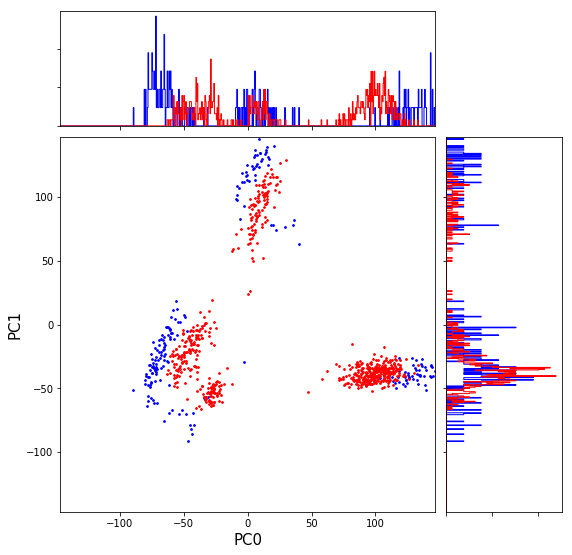

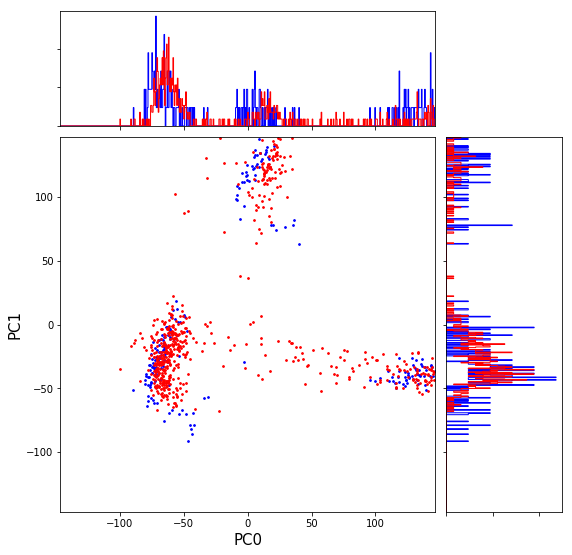

In [13]:
%matplotlib inline
calibratedSource = calibMMDNet.predict(source)

##################################### qualitative evaluation: PCA #####################################
pca = decomposition.PCA()
pca.fit(target)

# project data onto PCs
target_sample_pca = pca.transform(target)
projection_before = pca.transform(source)
projection_after = pca.transform(calibratedSource)

# choose PCs to plot
pc1 = 0
pc2 = 1
axis1 = 'PC'+str(pc1)
axis2 = 'PC'+str(pc2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_before[:,pc1], 
               projection_before[:,pc2], axis1, axis2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_after[:,pc1], 
               projection_after[:,pc2], axis1, axis2)

In [14]:
# df = pd.DataFrame(calibratedSource)
# df

In [15]:
# calibratedSourcePath = os.path.join(io.DeepLearningRoot(), 'data/calibratedBatch1-gtex-20PCs.csv')
# df.to_csv(calibratedSourcePath)